<a href="https://colab.research.google.com/github/ElaStain/InteligenciaArticial_lcdn4toSem/blob/main/Exposici%C3%B3n/freelance_pricing_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ESTIMACIÓN DE PRECIOS EN OFERTAS FREELANCE CON MLP

## Preprocesamiento y análisis

📦 1. Librerías base

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans

📂 2. Cargar dataset

In [3]:
df_freelance = pd.read_csv('/content/fiverr_clean.csv', encoding='latin1')
print("✅ Dataset cargado correctamente.")
display(df_freelance.head())

✅ Dataset cargado correctamente.


,Unnamed: 0,ï..Category,Subcat,name,price,stars,votes
0,1,Programming & Tech,Data Analysis & Reports,build automated and insightful power bi report,137.76,5.0,10
1,2,Lifestyle,Greeting Cards & Videos,get kermit to personalize a video birthday gre...,4.44,5.0,1k+
2,3,Programming & Tech,Website Builders & CMS,build or redesign your existing squarespace we...,66.66,5.0,68
3,4,Lifestyle,Cooking Lessons,create original eastern food cooking video recipe,17.78,4.9,5
4,5,Writing & Translation,Legal Writing,write gdpr privacy policy and terms and condit...,8.89,5.0,2


🔍 3. Exploratory Data Analysis (EDA)

In [4]:
print(f"\n🔹 Shape: {df_freelance.shape}")
print("\n🔹 Columnas:", list(df_freelance.columns))
print("\n🔍 Tipos de datos:")
print(df_freelance.dtypes)
print("\n❗ Valores nulos por columna:")
print(df_freelance.isnull().sum())


🔹 Shape: (6183, 7)

🔹 Columnas: ['Unnamed: 0', 'ï..Category', 'Subcat', 'name', 'price', 'stars', 'votes']

🔍 Tipos de datos:
Unnamed: 0      int64
ï..Category    object
Subcat         object
name           object
price          object
stars          object
votes          object
dtype: object

❗ Valores nulos por columna:
Unnamed: 0     0
ï..Category    0
Subcat         0
name           0
price          0
stars          0
votes          0
dtype: int64


💲 4. Limpieza de datos numéricos

In [5]:
df_freelance['price'] = (
    df_freelance['price'].astype(str).str.replace(',', '', regex=False)
)
df_freelance['price'] = pd.to_numeric(df_freelance['price'], errors='coerce')
df_freelance['stars'] = pd.to_numeric(df_freelance['stars'], errors='coerce')


# Convertir la columna 'votes', se traduce como votos e implica el número de usuarios que rankearon
if 'votes' in df_freelance.columns:
    df_freelance['votes'] = pd.to_numeric(df_freelance['votes'], errors='coerce')
else:
    df_freelance['votes'] = 0

🔥 5. Correlación entre precio y estrellas

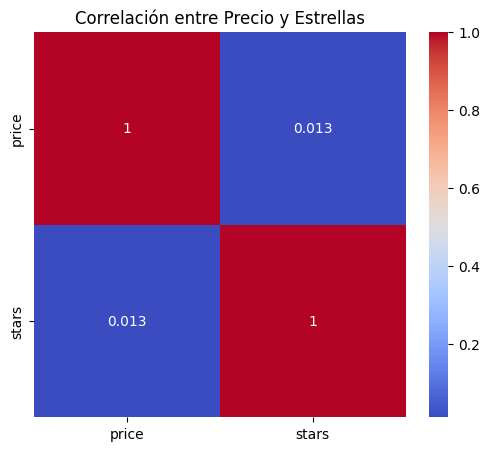

📈 Correlación:
          price     stars
price  1.000000  0.012781
stars  0.012781  1.000000


In [6]:
numeric_df = df_freelance[['price', 'stars']].dropna()
corr = numeric_df.corr()

plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlación entre Precio y Estrellas')
plt.show()

print("📈 Correlación:")
print(corr)

🧩 6. Clustering de categorías

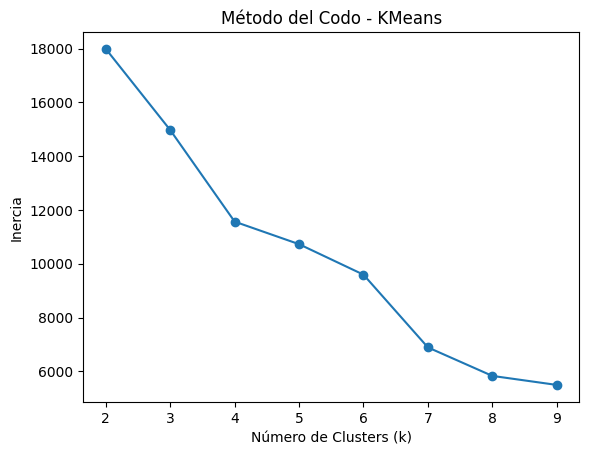

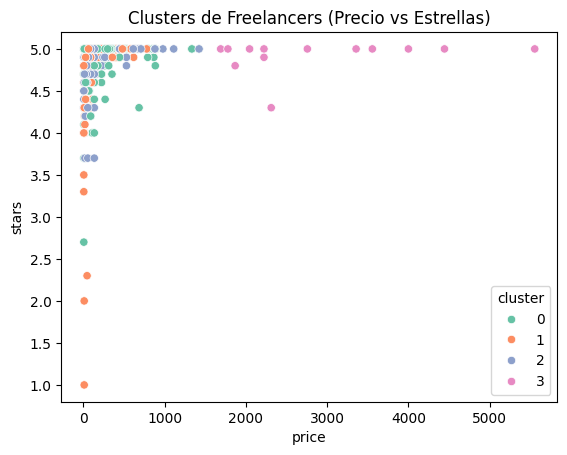

In [7]:
df_cluster = df_freelance.copy()
df_cluster.rename(columns={'ï..Category': 'Category'}, inplace=True)

# Codificar variables categóricas
for col in ['Category', 'Subcat']:
    df_cluster[col] = LabelEncoder().fit_transform(df_cluster[col])

# Eliminar filas con nulos
df_cluster.dropna(subset=['Category', 'Subcat', 'price', 'stars'], inplace=True)

# Normalizar
scaler = StandardScaler()
X = scaler.fit_transform(df_cluster[['Category', 'Subcat', 'price', 'stars']])

# Método del codo
inertia = []
for k in range(2, 10):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X)
    inertia.append(km.inertia_)

plt.plot(range(2, 10), inertia, marker='o')
plt.title('Método del Codo - KMeans')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.show()

# Elegir número de clusters
kmeans = KMeans(n_clusters=4, random_state=42)
df_cluster['cluster'] = kmeans.fit_predict(X)

# Visualización
sns.scatterplot(data=df_cluster, x='price', y='stars', hue='cluster', palette='Set2')
plt.title('Clusters de Freelancers (Precio vs Estrellas)')
plt.show()

💰 7. Promedios por categoría

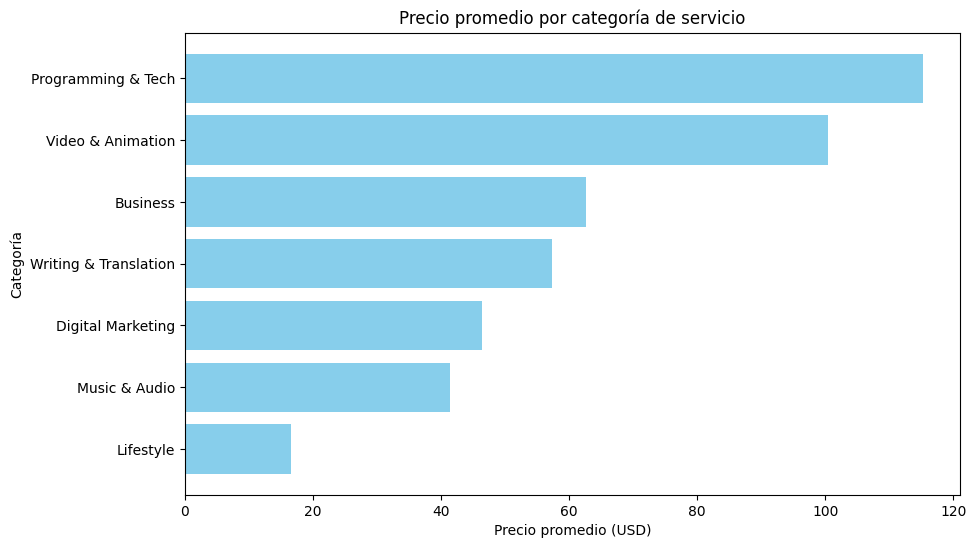

In [8]:
df_freelance.rename(columns={'ï..Category': 'Category'}, inplace=True)
category_stats = (
    df_freelance.groupby('Category')
    .agg(
        promedio_precio=('price', 'mean'),
        precio_min=('price', 'min'),
        precio_max=('price', 'max'),
        total_ofertas=('price', 'count'),
    )
    .sort_values(by='promedio_precio', ascending=False)
)

plt.figure(figsize=(10, 6))
plt.barh(category_stats.reset_index()['Category'],
         category_stats.reset_index()['promedio_precio'],
         color='skyblue')
plt.xlabel('Precio promedio (USD)')
plt.ylabel('Categoría')
plt.title('Precio promedio por categoría de servicio')
plt.gca().invert_yaxis()
plt.show()

🧮 8. Revisión de clusters y limpieza de outliers

In [9]:
cluster_means = df_cluster.groupby('cluster')['price'].mean()
print("\n📊 Precio promedio por cluster:\n", cluster_means)

cluster_counts = df_cluster['cluster'].value_counts()
print("\n📊 Número de registros por cluster:\n", cluster_counts)

# Eliminar cluster de outliers (3)
df_ready = df_cluster[df_cluster['cluster'] != 3].copy()

# Añadir votos
if 'votes' not in df_ready.columns:
    df_ready['votes'] = df_freelance['votes']


📊 Precio promedio por cluster:
 cluster
0      57.706373
1      40.274593
2      58.576246
3    2907.769231
Name: price, dtype: float64

📊 Número de registros por cluster:
 cluster
0    2440
1    1620
2    1617
3      13
Name: count, dtype: int64


✅ 9. Dataset final para el MLP

In [10]:
df_ready = df_ready[['Category', 'Subcat', 'stars', 'votes', 'cluster', 'price']]
print("\n✅ Dataset listo para el modelo MLP:")
display(df_ready.head())
print(f"\nShape final: {df_ready.shape}")


✅ Dataset listo para el modelo MLP:


,Category,Subcat,stars,votes,cluster,price
0,4,33,5.0,10.0,2,137.76
1,2,52,5.0,NaN,1,4.44
2,4,122,5.0,68.0,0,66.66
3,2,27,4.9,5.0,1,17.78
4,6,60,5.0,2.0,2,8.89



Shape final: (5677, 6)


## MLP

In [30]:
# Filtrar precios fuera de rango (eliminar outliers extremos)
q1 = df_cluster['price'].quantile(0.01)
q3 = df_cluster['price'].quantile(0.99)
df_cluster = df_cluster[(df_cluster['price'] >= q1) & (df_cluster['price'] <= q3)]

# Reemplazar posibles infinitos o nulos residuales
df_cluster.replace([np.inf, -np.inf], np.nan, inplace=True)
df_cluster.dropna(inplace=True)

# Variables predictoras y objetivo
X = df_cluster[['Category', 'Subcat', 'stars', 'votes', 'cluster']]
y = df_cluster[['price']]

# Escalar variables (min-max para evitar overflows)
from sklearn.preprocessing import MinMaxScaler

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Dividir 80/20
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42
)

print("✅ Datos filtrados, limpios y normalizados.")
print(f"Rango de precios después del filtrado: {df_cluster['price'].min()} - {df_cluster['price'].max()}")
print("Tamaño de entrenamiento:", X_train.shape)
print("Tamaño de prueba:", X_test.shape)


✅ Datos filtrados, limpios y normalizados.
Rango de precios después del filtrado: 4.44 - 266.63
Tamaño de entrenamiento: (4327, 5)
Tamaño de prueba: (1082, 5)


In [31]:
from tensorflow.keras import regularizers

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],),
          kernel_regularizer=regularizers.l2(0.001)),
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(16, activation='relu'),
    Dense(1)
])

optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### 🚀 3. Entrenamiento del modelo

In [32]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    verbose=1
)

print("✅ Entrenamiento completado.")

Epoch 1/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0836 - mae: 0.1306 - val_loss: 0.0673 - val_mae: 0.1269
Epoch 2/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0615 - mae: 0.1249 - val_loss: 0.0558 - val_mae: 0.1268
Epoch 3/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0530 - mae: 0.1336 - val_loss: 0.0503 - val_mae: 0.1249
Epoch 4/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0504 - mae: 0.1329 - val_loss: 0.0463 - val_mae: 0.1298
Epoch 5/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0437 - mae: 0.1281 - val_loss: 0.0445 - val_mae: 0.1340
Epoch 6/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0453 - mae: 0.1347 - val_loss: 0.0429 - val_mae: 0.1297
Epoch 7/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0410 - mae: 0.1278 - val_loss: 0.0417 - val_mae: 0.1288
Epoch 8/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0424 - mae: 0.1337 - val_loss: 0.0412 - val_mae: 0.1251
Epoch 9/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms

### 📈 4. Curvas de aprendizaje

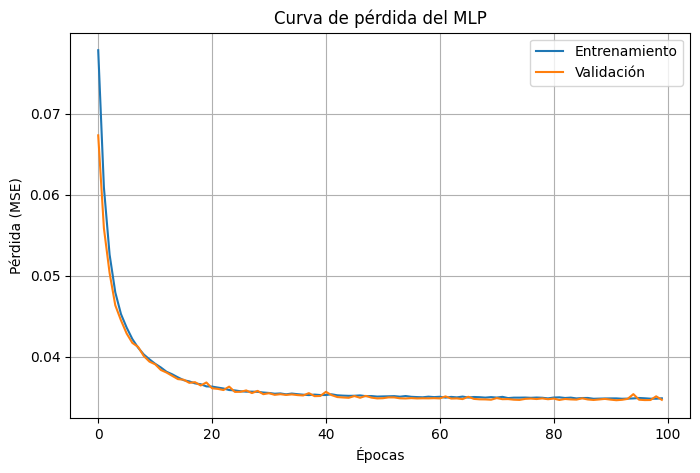

In [33]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (MSE)')
plt.title('Curva de pérdida del MLP')
plt.legend()
plt.grid(True)
plt.show()

In [34]:
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"📊 MSE final: {loss:.4f}")
print(f"📏 MAE final: {mae:.4f}")

# Si quieres recuperar los precios originales:
# y_pred = scaler_y.inverse_transform(model.predict(X_test))

📊 MSE final: 0.0347
📏 MAE final: 0.1285


In [37]:
# Hacer predicciones con el conjunto de prueba
y_pred = model.predict(X_test)

# Mostrar algunas comparaciones
for i in range(5):
    print(f"Valor real: {y_test[i][0]:.3f} | Predicción: {y_pred[i][0]:.3f}")

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Valor real: 0.085 | Predicción: 0.170
Valor real: 0.085 | Predicción: 0.159
Valor real: 0.119 | Predicción: 0.121
Valor real: 0.136 | Predicción: 0.125
Valor real: 0.186 | Predicción: 0.162


In [38]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Predicciones
y_pred = model.predict(X_test)

# Desnormalizamos (si tus datos estaban normalizados con MinMaxScaler)
y_pred_denorm = scaler_y.inverse_transform(y_pred)
y_test_denorm = scaler_y.inverse_transform(y_test)

# Métricas
mae = mean_absolute_error(y_test_denorm, y_pred_denorm)
mse = mean_squared_error(y_test_denorm, y_pred_denorm)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_denorm, y_pred_denorm)

print("📏 MAE:", round(mae, 4))
print("📉 MSE:", round(mse, 4))
print("📊 RMSE:", round(rmse, 4))
print("📈 R²:", round(r2, 4))

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
📏 MAE: 33.6994
📉 MSE: 2355.1504
📊 RMSE: 48.5299
📈 R²: 0.0463


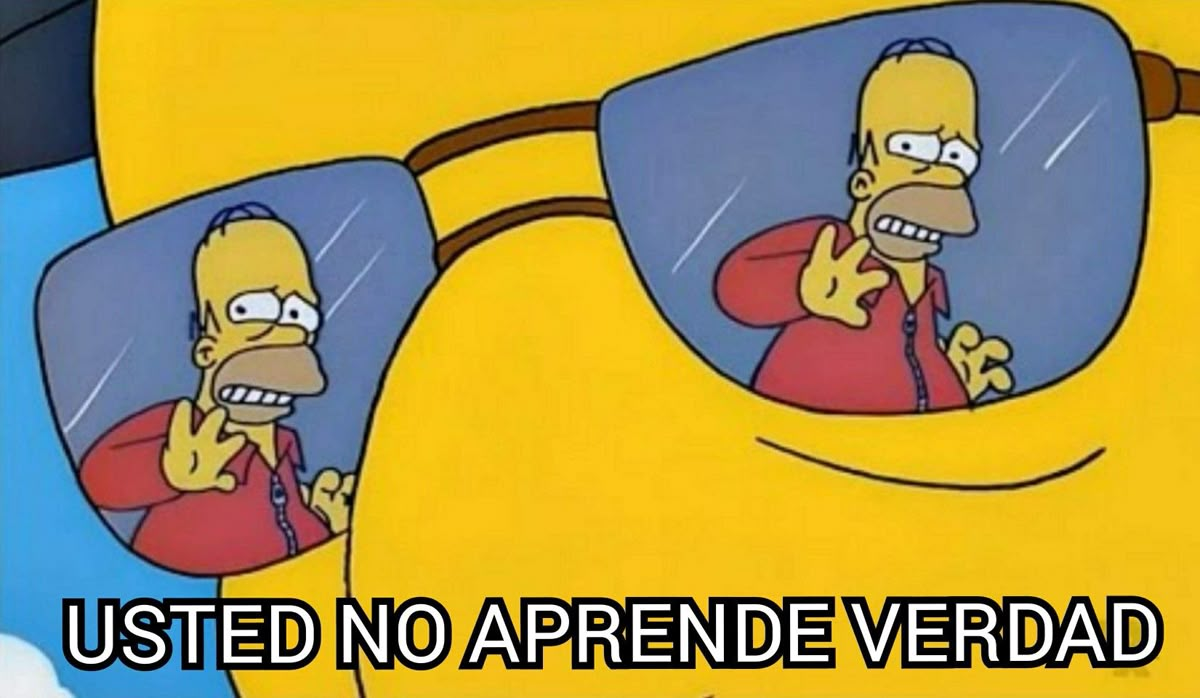